# Surprisingly positive outcomes

This notebook walks through the heuristic of identifying samples with surprisingly positive outcomes. Specifically, it replicates Figure 3c.

## Loading data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
data_prefix = ''
datapath = '<REPLACE WITH OUTPUT PATH>'
figpath = './figs'
import sys; sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import pickle as pkl
import shelve
import numpy as np
import pandas as pd
from trajectoryInspection import mimic_utils as utils
from trajectoryInspection.mimic_config import colbin, collog, colnorm, feature_vars_map
from trajectoryInspection import mdp_utils as cf

# Avoid Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import logging as log
import sys
log.basicConfig(stream=sys.stdout, level=log.DEBUG)
log.getLogger('matplotlib').setLevel(log.WARNING)

from tqdm import tqdm_notebook as tqdm

# Max number of time steps
N_HORIZON=20

# Number of simulated trajectories / real trajectory
NCFSAMPS=5

# Since we've already learned a policy, no discounting here
DISCOUNT=1.

# Number of actions
nact = 25
# Number of states (clusters)
ncl = 750
# Indices
death_state_idx = ncl
lives_state_idx = ncl+1

In [3]:
# Read-only access to the data
data_dict = shelve.open("{}/{}data_dict.db".format(datapath, data_prefix), flag='r')

In [4]:
best_results = data_dict['best_results']

In [5]:
traj_train = data_dict['best_results']['traj_train']
traj_test = data_dict['traj_test']
final_obs_b_soft = data_dict['best_results']['obs_b_soft']
final_rl_pol_soft = data_dict['best_results']['rl_pol_soft']
final_rl_pol = data_dict['best_results']['rl_pol']

## Generating Model-Based Trajectories

The following code defines the MDP from which we will be generating model-based rollouts

In [6]:
# Define the MDP we use for model-based rollouts
mdp_train_raw, mdp_train_raw_sampler, raw_obs_b = utils.create_mdp(
    data_dict['best_results']['traj_train'],
    remove_low_freq=False, 
    insta_death=False,
    soften=False,
    enforce_complete=False,
    nact=nact, ncl=ncl, 
    death_state_idx=death_state_idx, lives_state_idx=lives_state_idx,
    return_obs_b=True)

# Collect the test trajectories
test_samps = data_dict['test_samps']
test_idx_flat = data_dict['test_idx_flat']
test_idx = np.broadcast_to(test_idx_flat[:, np.newaxis], (test_idx_flat.shape[0], N_HORIZON))

This code generates the model-based rollouts, but this can take some time (e.g., 1 hour) so we save the results in a shelve file and then re-load when replicating results

Note: After this code runs, we recommend commenting it out, and then re-loading from file.

In [ ]:
# Generate model-based rollouts
np.random.seed(0)
test_samps_mb = mdp_train_raw_sampler.cf_trajectory(
    test_samps,
    cf_policy=rl_pol,
    n_cf_samps=NCFSAMPS, use_tqdm=True,
    use_mb=True)  # This conditions on only the first state

# Back up our results
mb_dict = shelve.open("{}/mb_samples.db".format(datapath))
mb_dict['test_samps_mb'] = test_samps_mb
mb_dict.close()

In [8]:
# Re-load our results
mb_dict = shelve.open("{}/mb_samples.db".format(datapath), flag='r')
test_samps_mb = mb_dict['test_samps_mb']

In [9]:
feature_lookup = data_dict['feature_lookup']
action_lookup = data_dict['action_lookup']

# Actual Trajectories with all features
traj_test_full = data_dict['traj_test_full']

# Model-based trajectories with appropriate indexing and only state / action / reward variables
traj_test_mb = utils.recover_index(test_samps_mb, test_idx, 
                                   # This argument should be renamed, really asking 
                                   # "is there more than one trajectory per ICUstayID?"
                                   is_cf=True)

# Model-based trajectories with imputed features
traj_test_full_mb = utils.traj_to_features(traj_test_mb, feature_lookup, action_lookup)

NSIMSAMPS = test_samps_mb.shape[0]

## Generating Figure 3c

This figure plots difference in reward by initial state

In [10]:
# Used later to get per-trajectory summaries of rollouts
def get_summary_df(traj, is_cf=False):
    gb = ['icustayid', 'cf_index'] if is_cf else 'icustayid'
    
    df = traj.groupby(gb).agg(
    {'reward': 'sum', 
     'action_idx': ['count', 'last'], 
     'from_state_idx':['first', 'last']})

    df.columns = ['_'.join(col).rstrip('_') for col in df.columns.values]
    d = dict(zip(df.columns.values, ['reward', 'traj_len', 'final_action', 'initial_state', 'final_state']))
    df.rename(columns = d, inplace=True)
    
    return df

In [11]:
# These summarize the MB and actual trajectories, averaging over the replicates in the former
traj_test_summary = get_summary_df(traj_test)
traj_test_mb_summary = get_summary_df(traj_test_mb, is_cf=True)

reward_diff = traj_test_mb_summary.mean()['reward'] - traj_test_summary.mean()['reward']

# These calculate the reward by each state
reward_by_state_actual = traj_test_summary.groupby('initial_state').agg([np.mean, np.size])['reward']
reward_by_state_actual['pct'] = reward_by_state_actual['size'] / reward_by_state_actual['size'].sum()

reward_by_state_mb = traj_test_mb_summary.groupby('initial_state').agg([np.mean, np.size])['reward']
reward_by_state_mb['pct'] = reward_by_state_mb['size'] / reward_by_state_mb['size'].sum()

# These are the values we end up plotting
plot_values = (reward_by_state_mb - reward_by_state_actual)['mean'].sort_values()

In [12]:
from matplotlib.patches import Ellipse
from matplotlib.offsetbox import (TextArea, AnnotationBbox)

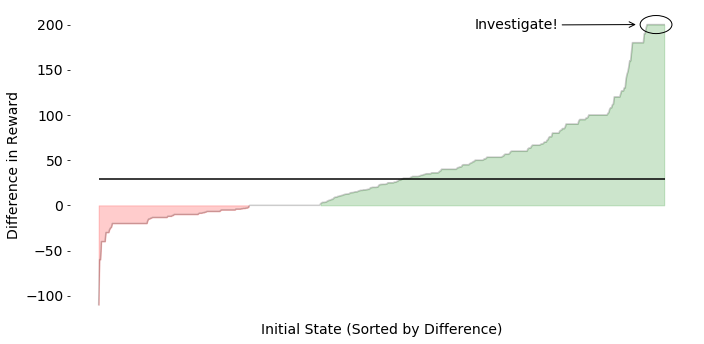

In [13]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(10, 5))
xrange = range(plot_values.shape[0])
ax.fill_between(xrange, 0, plot_values.values, where=(plot_values.values > 0), color='g', alpha=0.2)
ax.plot(plot_values.values, color='k', alpha=0.2)
ax.fill_between(xrange, 0, plot_values.values, where=(plot_values.values < 0), color='r', alpha=0.2)
ax.set_xlabel('Initial State (Sorted by Difference)')
ax.set_ylabel('Difference in Reward')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

xy = (plot_values.shape[0]-10, 200)
circ = Ellipse(xy, 35, 20, color='k', fill=False)
ax.add_artist(circ)
ax.annotate("Investigate!", (xy[0]-20, xy[1]), xytext=(xy[0]-200, xy[1]-5), arrowprops={'arrowstyle': '->'})

ax.set_frame_on(False)

ax.hlines(reward_diff, xmin=0, xmax=plot_values.shape[0], label='Weighted Average')

plt.tight_layout()
plt.show()